To add:
- locally weighted
- L1/L2 Regularization
- ADAM/lbfgs...
- gradient clippings

Learned:
- Gradient explosion: if learning rate too high, updates begin to spiral as each sequential update over corrects
- Add the intercept term to dataset as extra col before doing any modeling
- Data scaling: can mess up model as certain features become much more impactful on linear combination
- OOP is necessary: super convenient way to store/access data, much cleaner, barely any info passed as args, 
but there is a balance, easy to lose track of what objects are being handeled
- Convert pd to np: faster and np very contained
- Lot of convenient interactions with pd: use documentation/chat, if you think it exists, probably does
- Experiment with epochs, learning rates, and grad types, just gotta tune it slightly and monitor costs/grads
- Shuffle data in mini-batches: less noise

In [1]:
#import libraries and dataset
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

boston_df = pd.read_csv('boston.csv')

Built-in Inverse Link and Cost Functions

In [2]:
def linear_identity(theta, input):
        return input @ theta

def linear_MSE(theta,X,Y):
    return np.mean((((X @ theta)  - Y) ** 2)/2)

def logit_sigmoid(theta, input):
    return 1 / (1 + np.exp(-(input @ theta)))

def logit_loss(theta,X,Y,epsilon=1e-15):
    sigmoid = logit_sigmoid(theta, X)
    sigmoid = np.clip(sigmoid, epsilon, 1 - epsilon)
    return np.mean(-(Y*np.log(sigmoid) + (1-Y)*(np.log(1-(sigmoid)))))

data_split to obtain chosen features and response

In [3]:
def data_split(df,fts,res):
    #slice df to get inputs and responses
    X = df[fts]
    Y = df[res]
    return (X,Y)

In [4]:
class GLM:
    #allows user to pick own learning_rate, max_epochs, convergence_level, and threshold values
    def __init__(self, GLM_type, learning_rate = 0.001, max_epochs = 1000,
                 convergence_level = .00001):
        #assigning attributes
        self.convergence_level = convergence_level
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.cost_storage = None
        self.theta = None
        self.batch_size = None
        self.threshold = None
        self.X_train, self.X_test, self.Y_train, self.Y_test, self.Y_pred = (None,None,None,None,None)

        if GLM_type == "linear":
            self.inverse_link = linear_identity
            self.cost = linear_MSE
        elif GLM_type == "logit":
            self.inverse_link = logit_sigmoid
            self.cost = logit_loss
        
        self.GLM_type = GLM_type
        
    #fit method which does the hardwork
    #choose dataset, features, response, gradient descent type,
    #batch size if mini-batch, and pre-existing theta estimate
    #input fts as list of strings
    #res as individual str
    def fit(self, df, features, response, grad_type = "mini-batch",
            batch_size = 32, theta = None, threshold = .5):
        
        #set threshold and safety
        self.threshold = threshold


        #get df, checks safety in data_slplit
        X,Y = data_split(df,features,response)

        #define and store datasets
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

        self.X_train = self.X_train.to_numpy()
        self.Y_train = self.Y_train.to_numpy()

        self.X_train = np.concatenate([np.ones((self.X_train.shape[0],1)), self.X_train], axis=1)

        self.X_test = self.X_test.to_numpy()
        self.Y_test = self.Y_test.to_numpy()

        self.X_test = np.concatenate([np.ones((self.X_test.shape[0],1)), self.X_test], axis=1)

        #define cost_storage to store cost at each epoch
        self.cost_storage = np.array([])

        #set batch_size based on grad_type and safety
        if grad_type == "stochastic":
            self.batch_size = 1
        elif grad_type == "batch":
            self.batch_size = len(self.X_train)
        elif grad_type == "mini-batch":
            #set batchsize, default of 32
            self.batch_size = batch_size

        #set estimate of theta and safety
        if theta == None:
            self.theta = np.zeros(self.X_train.shape[1])
        else:
            self.theta = theta
        
        #optimize
        self.theta = self.gradient_descent()
        return self.theta

    #finds optimal theta values
    def gradient_descent(self):
        
        for epoch in range(self.max_epochs):
            #track cost
            prev_cost = self.cost(self.theta,self.X_train,self.Y_train)
            self.cost_storage = np.append(self.cost_storage,prev_cost)

            #shuffle data to prevent overfitting
            indices = np.random.permutation(len(self.X_train))
            X_shuffled = self.X_train[indices]
            Y_shuffled = self.Y_train[indices]

            for i in range(0, len(self.X_train), self.batch_size):
                #initialize grad vector
                grad = np.zeros(len(self.theta))

                # Create mini-batches
                X_batch = X_shuffled[i:i+self.batch_size]
                Y_batch = Y_shuffled[i:i+self.batch_size]

                # Compute gradient for the mini-batch, divide by size of batch
                for j in range(len(X_batch)):
                    input = X_batch[j]
                    response = Y_batch[j]
                    grad += (self.inverse_link(self.theta,input) - response) * input
                grad /= len(X_batch)

                # Update parameters
                self.theta = self.theta - self.learning_rate * grad
                #to monitor cost and theta value
                if epoch % 100 == 0:
                    print(self.theta,"theta")
                    print(prev_cost)

                #calculate cost after update
                curr_cost = self.cost(self.theta, self.X_train, self.Y_train)

            #convergence
            if abs(prev_cost - curr_cost) < self.convergence_level:
                print("converged")
                return self.theta
            
            #reset prev_cost
            prev_cost = curr_cost

        #hit max_epochs
        print("max_epochs")
        return self.theta

    #get array of predicted vals based on X_test
    def predict(self):
        if self.GLM_type == "linear":
            self.Y_pred = self.inverse_link(self.theta, self.X_test)
            return self.Y_pred
        elif self.GLM_type == "logit":
            self.Y_pred = self.inverse_link(self.theta, self.X_test)
            #get actually class predictions based on chosen threshold
            class_labels = np.zeros_like(self.Y_pred, dtype=int)
            class_labels[self.Y_pred >= self.threshold] = 1
            return class_labels

    #returns theta value
    def parameters(self):
        return self.theta

    #returns array of total cost at each epoch
    def cost(self):
        return self.cost_storage
    
    #plots cost as function of epoch, demonstrate convergence
    def plot_cost(self):
        plt.plot(self.cost_storage)
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.title('Cost over Epochs')
        plt.grid(True)
        plt.show()
    
    #plots predicted vs acutal response values for linear regression
    def plot_predict(self):
        plt.scatter(self.Y_test, self.Y_pred, alpha=0.7, edgecolors="k", s=100)
        plt.plot([min(self.Y_test), max(self.Y_test)], [min(self.Y_test), max(self.Y_test)], 'r--', lw=2)  # Reference line
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predicted vs Actual Values')
        plt.grid(True)
        plt.show()
     
    def performance_metrics(self):
        #calcualtes mse, mae, and R^2
        if self.GLM_type == "linear":
            mse = mean_squared_error(self.Y_test, self.Y_pred)
            mae = mean_absolute_error(self.Y_test, self.Y_pred)
            r2 = r2_score(self.Y_test, self.Y_pred)
            print(f"Parameters : {self.parameters()}")
            print(f"Mean Squared Error: {mse}")
            print(f"Mean Absolute Error: {mae}")
            print(f"R-squared: {r2}")

        #calculates accuracy, precision, recall, and f1 score
        elif self.GLM_type == "logit":
            accuracy = accuracy_score(self.Y_test, self.Y_pred)
            precision = precision_score(self.Y_test, self.Y_pred)
            recall = recall_score(self.Y_test, self.Y_pred)
            f1 = f1_score(self.Y_test, self.Y_pred)
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"F1 Score: {f1}")

my linear regression

[0.0215375  0.003975   0.24150159] theta
303.27769801980196
[0.03928873 0.00615156 0.43029624] theta
303.27769801980196
[0.05560255 0.00805063 0.56612499] theta
303.27769801980196
[0.07401366 0.00941281 0.69281206] theta
303.27769801980196
[0.08699273 0.01044717 0.80454033] theta
303.27769801980196
[0.10027017 0.01154735 0.84800134] theta
303.27769801980196
[0.11884323 0.01168089 0.95834879] theta
303.27769801980196
[0.12818808 0.01246379 1.01646213] theta
303.27769801980196
[0.13880565 0.01246379 1.03509573] theta
303.27769801980196
[0.14567219 0.01330087 1.03976093] theta
303.27769801980196
[0.15674249 0.01658876 1.05938218] theta
303.27769801980196
[0.16770936 0.01982426 1.07032779] theta
303.27769801980196
[0.17276948 0.02029908 1.02459938] theta
303.27769801980196
[9.53288219 1.35882527 0.63172043] theta
97.28533204184548
[9.53551036 1.35881827 0.59592083] theta
97.28533204184548
[9.54077967 1.35881715 0.58717275] theta
97.28533204184548
[9.54459179 1.36015023 0.57044846] theta
97

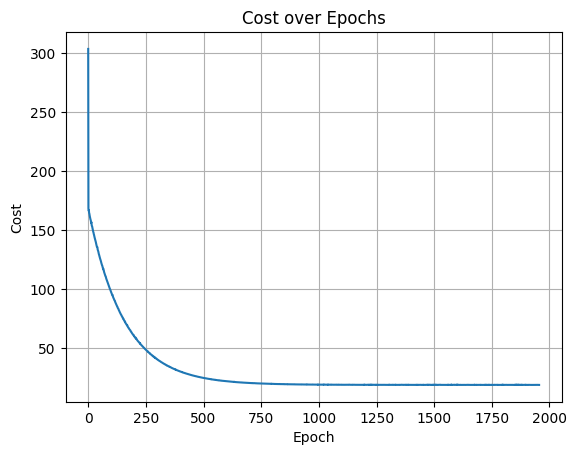

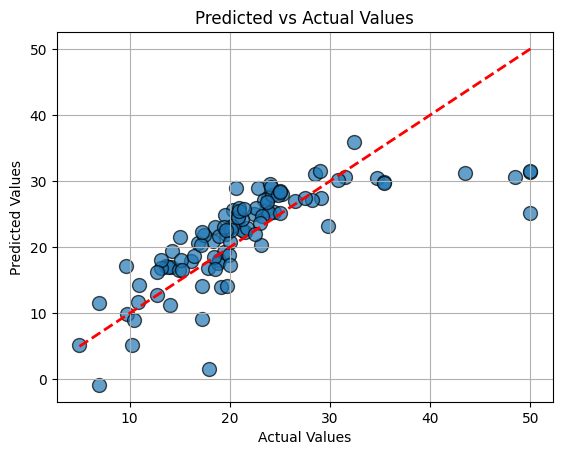

Parameters : [34.24628283  4.98632524 -0.94852909]
Mean Squared Error: 32.386020971327405
Mean Absolute Error: 3.94399144074588
R-squared: 0.5583751502288543


In [5]:
lin_features_chosen = ["CHAS","LSTAT"]

my_lin_model = GLM(GLM_type = "linear", learning_rate = .001, max_epochs = 2000, convergence_level = .00001)
my_lin_model.fit(boston_df, lin_features_chosen, "MEDV",grad_type = "mini-batch")
my_lin_model.parameters()
my_lin_model.predict()

my_lin_model.plot_cost()
my_lin_model.plot_predict()
my_lin_model.performance_metrics()

sklearn linear regression

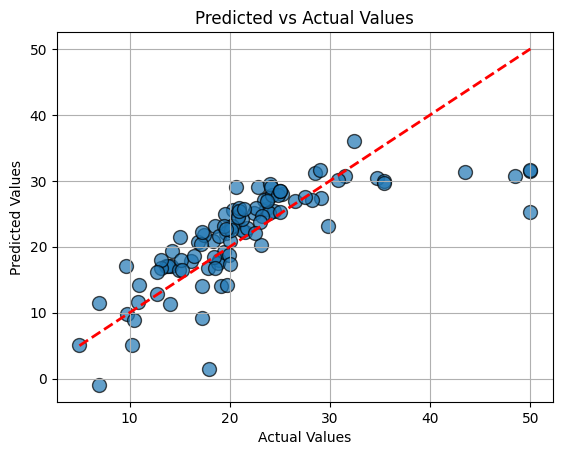

34.31494988461766 [ 5.0301961  -0.95361311]
Mean Squared Error: 32.42681807949245
Mean Absolute Error: 3.950810238612506
R-squared: 0.5578188294390778


In [6]:
sklearn_LR_model = LinearRegression()
X,Y = data_split(boston_df,lin_features_chosen,"MEDV")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
sklearn_LR_model.fit(X_train, Y_train)

slope = sklearn_LR_model.coef_
intercept = sklearn_LR_model.intercept_

Y_pred = sklearn_LR_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

plt.scatter(Y_test, Y_pred, alpha=0.7, edgecolors="k", s=100)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'r--', lw=2)  # Reference line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.show()

print(intercept, slope)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")